# malProfile

Should be on modern template, with the following boxes checked:

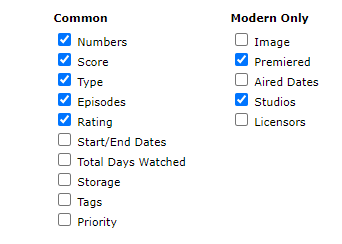

ideas:

1. malProfile - current problems: password login, scrolling down on profile, big function for scraping a show
2. malAnime
3. Prediction (combines 1 and 2, user input or just does it for all)
4. NetworkX graph for similarity between shows (that works for 1 or 2)

In [23]:
!pip install selenium

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import numpy as np
import time
import random

In [24]:
# User's profile page
user_profile = 'Jebby_Lin'


login = True
username = 'username'
password = 'password'

In [25]:
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
#options.add_argument('--headless') -- using headless mode currently leads to NoSuchElementException 
driver = webdriver.Chrome('./chromedriver', options=options)

In [26]:
# get a reference to the download menu. This will run before the page has 
# finished loading, so we stick it in a while loop and just keep looping
# until we're successful.
def find_by_id(element_id):
    while True:
        try:
            target = driver.find_element_by_id(element_id)
        except NoSuchElementException:
            time.sleep(0.2)
            continue
        else:
            break
    return target

def find_by_class(element_class):
    while True:
        try:
            target = driver.find_element_by_class_name(element_class)
        except NoSuchElementException:
            time.sleep(0.2)
            continue
        else:
            break
    return target



Optional: if user has a private list, then a login is needed to search their profile (could be self or a friend's). 

In [27]:
if login:
    driver.get("https://myanimelist.net/login.php?from=%2F")
    driver.implicitly_wait(5)
    driver.find_element_by_xpath("//*[@id='loginUserName']").send_keys(username)
    driver.find_element_by_xpath("//*[@id='login-password']").send_keys(password)
    driver.find_element_by_xpath("//*[@class='inputButton btn-form-submit btn-recaptcha-submit']").click()

Get the number of total shows completed. Will be useful calculating how many times the scraper needs to scroll down, as MAL only loads 300 shows at a time.

In [28]:
user_link = "https://myanimelist.net/profile/" + user_profile


driver.get(user_link)
driver.get(user_link)
driver.implicitly_wait(3)
#findElement not working
#driver.findElement(By.xpath("//*[@class='di-ib fl-r lh10']")[1])
#driver.findElement(By.xpath("//h1[@class='di-ib fl-r lh10']")).getText()

In [29]:
e = driver.find_elements_by_xpath("//*[@class='di-ib fl-r lh10']")[1]
num_shows = int(e.text)
scrolls = max(((num_shows // 300) - 1), 0)
num_shows, scrolls

(451, 0)

## Sandbox

Transition to the actual list

In [366]:
status = 2
user_link = "https://myanimelist.net/animelist/" + user_profile + "?status=2&tag="

driver.get(user_link)

Scroll to bottom

In [350]:
SCROLL_PAUSE_TIME = 1

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

In [355]:
mal_list = find_by_id('list-container')
table = mal_list.find_element_by_tag_name('table')
rows = table.find_elements_by_tag_name('tbody')
#header_row = rows[0]
rows_text = [row.text.split('\n') for row in rows[1:]]
#df = pd.DataFrame(rows_text, columns = header_row.text.split('\n'))
df = pd.DataFrame(rows_text, columns = [i for i in np.arange(1, 6)])
df

,1,2,3,4,5
0,1 3-gatsu no Lion Watch Episode Video,Edit - More,9 TV,22,None
1,2 3-gatsu no Lion 2nd Season Watch Episode Video,Edit - More,10 TV,22,None
2,3 Accel World Watch Episode Video,Add - More,7 TV,24,"Edgy girl and dumbass, T H I C C (Jk just obes..."
3,4 Ahiru no Sora Watch Episode Video,Add - More,7 TV,50,None
4,5 Ajin,Add - More,6 TV,13,Kys to heal makes sense.
...,...,...,...,...,...
165,166 Yowamushi Pedal Movie,Add - More,7 Movie,1,None
166,167 Yowamushi Pedal: Glory Line Watch Episode ...,Add - More,5 TV,25,None
167,168 Yowamushi Pedal: Grande Road Watch Episode...,Add - More,8 TV,24,None
168,169 Yowamushi Pedal: New Generation Watch Epis...,Add - More,7 TV,25,None


In [280]:
df = df.drop([2], axis=1)
df["Title"] = (df[1].str.split(None, 1).str[1])
df = df.drop(1, axis=1)
df["Score"] = (df[3].str.split(None, 1).str[0])
df["Type"] = (df[3].str.split(None, 1).str[1])
df = df.drop(3, axis=1)
df["Rated"] = (df[5].str.split(None, 3).str[0])
df["Aired Month"] = (df[5].str.split(None, 3).str[1])
df["Aired Year"] = (df[5].str.split(None, 3).str[2])
df["Studio"] = (df[5].str.split(None, 3).str[3])
df = df.drop(5, axis=1)
df = df.rename(columns={4: "Episodes"})
df['Title'] = df['Title'].map(lambda x: x.replace(' Watch Episode Video', ''))

In [281]:
if status != 2:
    ep_split = df["Episodes"].str.split(" / ")
    df["Episodes Watched"] = ep_split.str[0]
    df["Episodes"] = ep_split.str[1]
else:
    df["Episodes Watched"] = df["Episodes"]

In [282]:
df["Status"] = "Dropped"
df.head(30)

,Episodes,Title,Score,Type,Rated,Aired Month,Aired Year,Studio,Episodes Watched,Status
0,13,Aku no Hana,-,TV,R,Spring,2013,Zexcs,-,Dropped
1,26,Azumanga Daioh,4,TV,PG-13,Spring,2002,J.C.Staff,8,Dropped
2,366,Bleach,5,TV,PG-13,Fall,2004,Studio Pierrot,110,Dropped
3,25,Boku no Hero Academia 4th Season,-,TV,PG-13,Fall,2019,Bones,6,Dropped
4,37,Death Note,5,TV,R,Fall,2006,Madhouse,27,Dropped
5,12,Happy Sugar Life,-,TV,R,Summer,2018,Ezόla,5,Dropped
6,23,Kaze ga Tsuyoku Fuiteiru,4,TV,PG-13,Fall,2018,Production I.G,11,Dropped
7,24,Lucky☆Star,-,TV,PG-13,Spring,2007,Kyoto Animation,4,Dropped
8,12,Mikakunin de Shinkoukei,5,TV,PG-13,Winter,2014,Doga Kobo,7,Dropped
9,26,Nagi no Asu kara,4,TV,PG-13,Fall,2013,P.A. Works,14,Dropped


In [283]:
def make_hyperlink(value):
    url = "https://myanimelist.net/anime/38408/Boku_no_Hero_Academia_4th_Season"
    return '=HYPERLINK("%s", "%s")' % (url.format(value), value)

df['Hyperlink'] = df['Title'].apply(lambda x: make_hyperlink(x))
#df

In [367]:
edit_region = driver.find_elements_by_xpath("//*[@class='List_LightBox']")[0]
edit_region.send_keys(Keys.CONTROL + Keys.ENTER)
driver.switch_to.window(driver.window_handles[1])

In [368]:
try:
    history_region = driver.find_element_by_xpath("//*[@class='thickbox']")
    history_region.send_keys(Keys.CONTROL + Keys.ENTER)
    driver.switch_to.window(driver.window_handles[2])
    
    list_region = driver.find_elements_by_xpath("//*[@class='spaceit_pad']")
    if (len(list_region) != 0):
        Date_Finished = list_region[0].text[18:-7]
        Date_Started = list_region[-1].text[18:-7]
    else:
        Date_Finished = ''
        Date_Started = ''
    
    driver.close()
    driver.switch_to.window(driver.window_handles[1])
    driver.close()
    driver.switch_to.window(driver.window_handles[0])
        
except NoSuchElementException:
    Date_Finished = ''
    Date_Started = ''
    
    driver.close()
    driver.switch_to.window(driver.window_handles[0])
#history_region.send_keys(Keys.CONTROL + Keys.ENTER)
#driver.switch_to.window(driver.window_handles[2])

Calling page(show) scrape function for all shows watched.

### Page Scrape Implementation

Merges page scrape file work with what personal info.

In [150]:
#driver.close()
#driver.switch_to.window(driver.window_handles[0])

In [433]:
# 1-5 from this class are header titles. Start at index 5 (#6).
all_shows = driver.find_elements_by_xpath("//*[@class='link sort']")[5:]
stopper = 20

#all_shows[0].send_keys(Keys.CONTROL + Keys.ENTER)
#assert len(driver.window_handles) > 1
#driver.switch_to.window(driver.window_handles[1])

ps_df = pd.DataFrame(columns=[
    "Title", "Hyperlink", "Episodes", "Score", "Synopsis", "Source", "Genres", "Duration", 
    "Ranked", "Popularity", "Members", "Favorites",
    "Watching", "Completed", "On-Hold", "Dropped", "Plan to Watch", "Total", 
    "1", "2", "3", "4", "5", "6", "7",
    "8", "9", "10", 
    "ScoredCount"
])


for i in all_shows:
    if stopper == 0:
        break
    i.send_keys(Keys.CONTROL + Keys.ENTER)
    assert len(driver.window_handles) > 1
    driver.switch_to.window(driver.window_handles[1])
    
    ps_df = page_scrape(ps_df, driver.current_url)
    
    driver.close()
    driver.switch_to.window(driver.window_handles[0])
    stopper -= 1
    
ps_df

KeyboardInterrupt: 

In [545]:
driver.close()
driver.switch_to.window(driver.window_handles[0])

Ignore "Episode" search on this page_scrape since it won't be used anyway

In [8]:
def page_scrape(df, link):
    
    
    malrow = {}
    
    ### MAIN PAGE ###

    
    #driver.get(link)  
    
    #0. Title
    wrapper_region = find_by_class("wrapper")
    title_region = wrapper_region.find_element_by_tag_name("h1")
    malrow["Title"] = title_region.text
    
    # Hyperlink

    malrow['Hyperlink'] = '=HYPERLINK("%s", "%s")' % (link.format(malrow["Title"]), malrow["Title"])

    # 1. Information Left Side
    wrapper_region = find_by_class("wrapper")
    content_region = wrapper_region.find_element_by_id("content")
    bord_region = content_region.find_element_by_class_name("borderClass")
    sty = bord_region.find_element_by_tag_name('div')
    rows = sty.find_elements_by_tag_name('div')

    def duration(st):
        minutes = 0
        if "sec" in st:
            minutes = int(st.split(" sec")[0]) / 60
            return minutes
        elif ("hr" in st) and ("min" in st):
            minutes = int(st.split(" hr")[0]) * 60
            rest = st.split(" hr")[1][2:]
            return int(rest.split(" min")[0]) + minutes
        elif "hr" in st:
            return int(st.split(" hr")[0]) * 60
        elif st == "Unknown":
            return None
        elif "min" in st:
            return int(st.split(" min")[0]) + minutes
    
    def raw2int(index, cutoff):
        if "A" in (rows[-(index)].text[cutoff:].replace(',', '')):
            return None
        return int(rows[-(index)].text[cutoff:].replace(',', ''))
    
    while (rows[-1].text[:10] != 'Favorites:'):
        rows.remove(rows[-1])

    malrow["Source"] = rows[-11].text[8:]
    malrow["Genres"] = rows[-10].text.split(": ")[1:][0].split(", ")
    malrow["Duration"] = duration(rows[-9].text[10:])
    
    if ("A" in rows[-7].text[7:]):
        malrow["ScoredCount"] = None
        malrow["Score"] = None
    else:
        malrow["ScoredCount"] = int(rows[-7].text[7:].split(" (")[1].split("by ")[1].split(" users")[0].replace(',', ''))
        malrow["Score"] = float(rows[-7].text[7:].split(" (")[0])
    
    malrow["Ranked"] = raw2int(5, 9)
    malrow["Popularity"] = raw2int(3, 13)
    malrow["Members"] = raw2int(2, 9)
    malrow["Favorites"] = raw2int(1, 10)
    
    # 2A. Information Right Side - Synopsis
    wrapper_region = find_by_class("wrapper")
    content_region = wrapper_region.find_element_by_id("content")
    bord_region = content_region.find_element_by_class_name("js-scrollfix-bottom-rel")
    synopsis_region = bord_region.find_element_by_tag_name('p')
    malrow["Synopsis"] = synopsis_region.text
    
    '''
    # 2B. Information Right Side - Staff
    big_region = bord_region.find_elements_by_class_name('pb24')[-1]
    char_region = big_region.find_elements_by_tag_name("div")[4]
    va_region = char_region.find_elements_by_class_name('borderClass')

    k = 0
    va_list = []
    for entry in va_region:
        if (k % 3 == 2):
            va_list.append(entry.text.split("\n")[0])
        k += 1

    malrow["Voice Actors"] = va_list
    '''
    
    ### STATS ###
    
    # 3. Stats
    time.sleep(np.random.rand() * 5)
    driver.get(link + "/stats")

    wrapper_region = find_by_class("wrapper")
    content_region = wrapper_region.find_element_by_id("content")
    bord_region = content_region.find_element_by_class_name("js-scrollfix-bottom-rel")
    stat_region = bord_region.find_elements_by_class_name('spaceit_pad')


    def stat2int(index, cutoff):
        return int(stat_region[index].text[cutoff:].replace(',', ''))

    def stat2score(index):
        return int(stat_region[index].text.replace('v', '(').split(' (')[1])

    malrow["Watching"] = stat2int(0, 9)
    malrow["Completed"] = stat2int(1, 11)
    malrow["On-Hold"] = stat2int(2, 9)
    malrow["Dropped"] = stat2int(3, 9)
    malrow["Plan to Watch"] = stat2int(4, 15)
    malrow["Total"] = stat2int(5, 7)
    
    if (len(stat_region) == 16):
        sum = 0
        for i in range(1, 11):
            malrow[str(i)] = stat2score(16 - i)
            sum += stat2score(16 - i)
        malrow["ScoredCount"] = sum
        for i in range(1, 11):
            malrow[str(i)] = malrow[str(i)] / sum * 100
    else:
        for i in range(1, 11):
            malrow[str(i)] = None
    

    # Final steps
    df = df.append(malrow, ignore_index=True)
    return df

### Combining both DFs

In [152]:
ps_df = ps_df.drop("Episodes", axis=1)

In [153]:
final_df = pd.merge(df, ps_df, on="Title")
final_df = final_df.rename(columns={"Score_x": "User Score", "Score_y": "MAL Score"})
final_df

,Episodes,Title,User Score,Type,Rated,Aired Month,Aired Year,Studio,MAL Score,Synopsis,...,2,3,4,5,6,7,8,9,10,ScoredCount
0,22,3-gatsu no Lion,10,TV,PG-13,Fall,2016,Shaft,8.421,Having reached professional status in middle s...,...,0.156693,0.267910,0.697455,1.874379,4.336479,13.074684,29.918886,30.887216,18.444740,202307
1,22,3-gatsu no Lion 2nd Season,-,TV,PG-13,Fall,2017,Shaft,9.001,"Now in his second year of high school, Rei Kir...",...,0.069453,0.130315,0.252037,0.726755,1.821541,6.269422,17.883891,32.504905,39.719466,139662
2,1,3-gatsu no Lion Recap,-,Special,PG-13,Fall,2016,Shaft,6.711,Recap of the first 11 episodes of 3-gatsu no L...,...,0.497362,0.723436,2.245667,13.112283,25.395629,31.077619,15.146948,5.290128,5.440844,6635
3,12,91 Days,8,TV,R,Summer,2016,Shuka,7.831,"As a child living in the town of Lawless, Ange...",...,0.146646,0.332224,1.153701,3.227076,8.291337,23.719443,33.334054,19.460222,10.188650,231169
4,1,91 Days: Mijikai Rousoku,-,Special,R,Summer,2016,Shuka,6.421,Recap of the first seven episodes of 91 Days s...,...,0.802265,1.761837,3.846154,17.280164,27.961303,24.862356,11.624980,5.545068,4.986629,12714
5,1,"91 Days: Toki no Asase/Subete no Kinou/Ashita,...",-,Special,R,Summer,2017,Shuka,6.881,This episode contains three stories.\n\nThe fi...,...,0.323656,0.745390,2.182228,9.008435,23.759317,35.298156,17.291095,6.286779,4.864653,20392
6,12,Absolute Duo,5,TV,R,Winter,2015,8bit,6.491,Individuals who can materialize weapons from t...,...,1.904886,3.128863,6.508920,13.022185,21.210075,26.110723,15.011592,6.880971,5.185413,253191
7,12,Africa no Salaryman (TV),5,TV,PG-13,Fall,2019,HOTZIPANG,6.531,Africa no Salaryman is a slapstick workplace c...,...,2.113492,3.836132,7.860452,14.099595,22.539085,25.911986,12.999421,5.370585,3.807180,6908
8,24,Akame ga Kill!,7,TV,R,Summer,2014,White Fox,7.501,Night Raid is the covert assassination branch ...,...,0.719005,1.450540,3.374046,5.677390,11.222149,22.409150,25.703767,17.220973,11.742050,941718
9,13,Amagi Brilliant Park,7,TV,PG-13,Fall,2014,Kyoto Animation,7.511,"Seiya Kanie, a smart and extremely narcissisti...",...,0.196375,0.439908,1.328876,4.472990,11.647721,30.520148,31.550238,13.586134,6.101355,284150


#### "One" Hot Encoding

In [154]:
#df['Genres'].fillna('NA', inplace = True)
flat_genre = [item for sublist in final_df["Genres"] for item in sublist]
set_genre = set(flat_genre)
unique_genre = list(set_genre)
#unique_genre.remove('NA')
final_df.reindex(final_df.columns.tolist() + unique_genre, axis=1, fill_value=0)

for index, row in final_df.iterrows():
    for val in row.Genres:
        final_df.loc[index, val] = 1


final_df = final_df.fillna(0)
final_df

,Episodes,Title,User Score,Type,Rated,Aired Month,Aired Year,Studio,MAL Score,Synopsis,...,Adventure,Fantasy,Shounen,Magic,Sci-Fi,Super Power,Mystery,Vampire,Parody,Psychological
0,22,3-gatsu no Lion,10,TV,PG-13,Fall,2016,Shaft,8.421,Having reached professional status in middle s...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,3-gatsu no Lion 2nd Season,-,TV,PG-13,Fall,2017,Shaft,9.001,"Now in his second year of high school, Rei Kir...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3-gatsu no Lion Recap,-,Special,PG-13,Fall,2016,Shaft,6.711,Recap of the first 11 episodes of 3-gatsu no L...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,91 Days,8,TV,R,Summer,2016,Shuka,7.831,"As a child living in the town of Lawless, Ange...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,91 Days: Mijikai Rousoku,-,Special,R,Summer,2016,Shuka,6.421,Recap of the first seven episodes of 91 Days s...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,"91 Days: Toki no Asase/Subete no Kinou/Ashita,...",-,Special,R,Summer,2017,Shuka,6.881,This episode contains three stories.\n\nThe fi...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,12,Absolute Duo,5,TV,R,Winter,2015,8bit,6.491,Individuals who can materialize weapons from t...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,12,Africa no Salaryman (TV),5,TV,PG-13,Fall,2019,HOTZIPANG,6.531,Africa no Salaryman is a slapstick workplace c...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,24,Akame ga Kill!,7,TV,R,Summer,2014,White Fox,7.501,Night Raid is the covert assassination branch ...,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,13,Amagi Brilliant Park,7,TV,PG-13,Fall,2014,Kyoto Animation,7.511,"Seiya Kanie, a smart and extremely narcissisti...",...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
final_df.to_csv(user_profile + 'Ratings.csv')

#### Recommendations Scrape Function (NetworkX)

In [ ]:
def recommendations_scrape():
    
    return

# One Function

In [30]:
all_df = pd.DataFrame()

for i in [1, 6, 2, 4]:
    status = i
    user_link = "https://myanimelist.net/animelist/" + user_profile + "?status=" + str(i) + "&tag="

    driver.get(user_link)

    SCROLL_PAUSE_TIME = 1

    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
    
    mal_list = find_by_id('list-container')
    table = mal_list.find_element_by_tag_name('table')
    rows = table.find_elements_by_tag_name('tbody')
    #header_row = rows[0]
    rows_text = [row.text.split('\n') for row in rows[1:]]
    #df = pd.DataFrame(rows_text, columns = header_row.text.split('\n'))
    df = pd.DataFrame(rows_text, columns = [i for i in np.arange(1, 6)])
    
    df = df.drop([2], axis=1)
    df["Title"] = (df[1].str.split(None, 1).str[1])
    df = df.drop(1, axis=1)
    df["Score"] = (df[3].str.split(None, 1).str[0])
    df["Type"] = (df[3].str.split(None, 1).str[1])
    df = df.drop(3, axis=1)
    df["Rated"] = (df[5].str.split(None, 3).str[0])
    df["Aired Month"] = (df[5].str.split(None, 3).str[1])
    df["Aired Year"] = (df[5].str.split(None, 3).str[2])
    df["Studio"] = (df[5].str.split(None, 3).str[3])
    df = df.drop(5, axis=1)
    df = df.rename(columns={4: "Episodes"})
    df['Title'] = df['Title'].map(lambda x: x.replace(' Watch Episode Video', ''))
    
    if status != 2:
        ep_split = df["Episodes"].str.split(" / ")
        df["Episodes Watched"] = ep_split.str[0]
        df["Episodes"] = ep_split.str[1]
    else:
        df["Episodes Watched"] = df["Episodes"]
        
    
    if status == 1:
        df["Status"] = "Currently Watching"
    elif status == 2:
        df["Status"] = "Completed"
    elif status == 3:
        df["Status"] = "On-Hold"
    elif status == 4:
        df["Status"] = "Dropped"
    elif status == 6:
        df["Status"] = "Plan to Watch"
    else:
        print("Error in status #")
        
        
        
    #------------------------------------
    
    # 1-5 from this class are header titles. Start at index 5 (#6).
    all_shows = driver.find_elements_by_xpath("//*[@class='link sort']")[5:]
    stopper = 2


    ps_df = pd.DataFrame(columns=[
        "Title", "Hyperlink", "Episodes", "Date Started", "Date Finished", "Score", "Synopsis", "Source", "Genres", "Duration", 
        "Ranked", "Popularity", "Members", "Favorites",
        "Watching", "Completed", "On-Hold", "Dropped", "Plan to Watch", "Total", "1", "2", "3", "4", "5", "6", "7",
        "8", "9", "10", "ScoredCount"
    ])

    date_index = 0
    date_finished = []
    date_started = []
    for i in all_shows:
        if stopper == 0:
            break
        i.send_keys(Keys.CONTROL + Keys.ENTER)
        time.sleep(np.random.rand() * 5)
        assert len(driver.window_handles) > 1
        driver.switch_to.window(driver.window_handles[1])

        ps_df = page_scrape(ps_df, driver.current_url)

        driver.close()
        driver.switch_to.window(driver.window_handles[0])
        time.sleep(np.random.rand() * 5)
        
        if login:
	        edit_region = driver.find_elements_by_xpath("//*[@class='List_LightBox']")[date_index]
	        edit_region.send_keys(Keys.CONTROL + Keys.ENTER)
	        time.sleep(np.random.rand() * 5)
	        driver.switch_to.window(driver.window_handles[1])

	        try:
	            history_region = driver.find_element_by_xpath("//*[@class='thickbox']")
	            history_region.send_keys(Keys.CONTROL + Keys.ENTER)
	            time.sleep(np.random.rand() * 4)
	            driver.switch_to.window(driver.window_handles[2])
	            time.sleep(np.random.rand() * 4 + 2) 

	            list_region = driver.find_elements_by_xpath("//*[@class='spaceit_pad']")
	            if (len(list_region) != 0):
	                date_finished.append(list_region[0].text[18:-7])
	                date_started.append(list_region[-1].text[18:-7])
	            else:
	                date_finished.append('')
	                date_started.append('')

	            driver.close()
	            driver.switch_to.window(driver.window_handles[1])
	            driver.close()
	            driver.switch_to.window(driver.window_handles[0])

	        except NoSuchElementException:
	            date_finished.append('')
	            date_started.append('')

	            
	            driver.close()
	            driver.switch_to.window(driver.window_handles[0])

	        time.sleep(np.random.rand() * 5)
	        date_index += 1
        
        #stopper -= 1

    ps_df = ps_df.drop("Episodes", axis=1)

    if login:
        ps_df["Date Finished"] = date_finished
	    ps_df["Date Started"] = date_started
   
    #---------------------------------------
    
    final_df = pd.merge(df, ps_df, on="Title")
    final_df = final_df.rename(columns={"Score_x": "User Score", "Score_y": "MAL Score"})
    
    all_df = pd.concat([all_df, final_df])

In [33]:
all_df

,Episodes,Title,User Score,Type,Rated,Aired Month,Aired Year,Studio,Episodes Watched,Status,...,2,3,4,5,6,7,8,9,10,ScoredCount
0,22,3-gatsu no Lion,10,TV,PG-13,Fall,2016,Shaft,22,Completed,...,0.156513,0.267603,0.698137,1.874207,4.338917,13.076494,29.926582,30.878991,18.440893,202539
1,22,3-gatsu no Lion 2nd Season,-,TV,PG-13,Fall,2017,Shaft,22,Completed,...,0.069363,0.130144,0.251707,0.725088,1.823447,6.269799,17.890522,32.497408,39.718975,139845
0,13,Aku no Hana,-,TV,R,Spring,2013,Zexcs,-,Dropped,...,2.210799,2.742016,5.263734,7.332354,12.866383,21.014312,21.084620,14.264733,9.993125,64004
1,26,Azumanga Daioh,4,TV,PG-13,Spring,2002,J.C.Staff,8,Dropped,...,0.325495,0.560793,1.426689,4.128692,8.276993,20.341496,28.387896,21.620731,14.606504,127498


In [11]:
#df['Genres'].fillna('NA', inplace = True)
flat_genre = [item for sublist in all_df["Genres"] for item in sublist]
set_genre = set(flat_genre)
unique_genre = list(set_genre)
#unique_genre.remove('NA')
all_df.reindex(all_df.columns.tolist() + unique_genre, axis=1, fill_value=0)

for index, row in all_df.iterrows():
    for val in row.Genres:
        all_df.loc[index, val] = 1


all_df = all_df.fillna(0)
all_df

,Episodes,Title,User Score,Type,Rated,Aired Month,Aired Year,Studio,Episodes Watched,Status,...,Music,Demons,Horror,Samurai,Sports,Police,Kids,Martial Arts,Shoujo,Shoujo Ai
0,22,3-gatsu no Lion,10,TV,PG-13,Fall,2016,Shaft,22,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,3-gatsu no Lion 2nd Season,-,TV,PG-13,Fall,2017,Shaft,22,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3-gatsu no Lion Recap,-,Special,PG-13,Fall,2016,Shaft,1,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,91 Days,8,TV,R,Summer,2016,Shuka,12,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,91 Days: Mijikai Rousoku,-,Special,R,Summer,2016,Shuka,1,Completed,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12,Otome wa Boku ni Koishiteru,3,TV,PG-13,Fall,2006,feel.,2,Dropped,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,25,Shinsekai yori,5,TV,R,Fall,2012,A-1 Pictures,8,Dropped,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,51,Soul Eater,4,TV,PG-13,Spring,2008,Bones,12,Dropped,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,24,Sword Art Online II,-,TV,PG-13,Summer,2014,A-1 Pictures,4,Dropped,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For Jeb's spreadsheet:

In [530]:
def jeb():
    order = ["Hyperlink", "Status", "Episodes Watched", "Episodes", "Date Started", "Date Finished", "User Score", "MAL Score", "Studio"]
    jeb_df = all_df[order]
    return jeb_df

new_df = jeb()

In [12]:
all_df.to_csv(user_profile + 'Ratings.csv')

In [531]:
new_df

,Hyperlink,Status,Episodes Watched,Episodes,Date Started,Date Finished,User Score,MAL Score,Studio
0,"=HYPERLINK(""https://myanimelist.net/anime/3164...",Completed,22,22,10/10/2020 at 02:31,04/11/2021 at 20:17,9,8.421,Shaft
1,"=HYPERLINK(""https://myanimelist.net/anime/3518...",Completed,22,22,10/10/2020 at 02:31,04/11/2021 at 20:17,10,9.001,Shaft
2,"=HYPERLINK(""https://myanimelist.net/anime/1175...",Completed,24,24,10/10/2020 at 02:31,04/11/2021 at 20:17,7,7.301,Sunrise
3,"=HYPERLINK(""https://myanimelist.net/anime/3740...",Completed,50,50,10/10/2020 at 02:31,04/11/2021 at 20:17,7,7.331,Diomedéa
4,"=HYPERLINK(""https://myanimelist.net/anime/3158...",Completed,13,13,10/10/2020 at 02:31,04/11/2021 at 20:17,6,7.471,Polygon Pictures
...,...,...,...,...,...,...,...,...,...
165,"=HYPERLINK(""https://myanimelist.net/anime/3041...",Completed,1,1,10/10/2020 at 02:31,04/11/2021 at 20:17,7,7.591,TMS Entertainment
166,"=HYPERLINK(""https://myanimelist.net/anime/3578...",Completed,25,25,10/10/2020 at 02:31,04/11/2021 at 20:17,5,7.581,TMS Entertainment
167,"=HYPERLINK(""https://myanimelist.net/anime/2427...",Completed,24,24,10/10/2020 at 02:31,04/11/2021 at 20:17,8,8.111,TMS Entertainment
168,"=HYPERLINK(""https://myanimelist.net/anime/3178...",Completed,25,25,10/10/2020 at 02:31,04/11/2021 at 20:17,7,7.681,TMS Entertainment


In [532]:
new_df.to_csv(user_profile + 'Ratings.csv')

In [528]:
all_df

,Episodes,Title,User Score,Type,Rated,Aired Month,Aired Year,Studio,Episodes Watched,Status,...,Martial Arts,Magic,Military,Shoujo,Cars,Music,Parody,Dementia,Ecchi,Vampire
0,22,3-gatsu no Lion,9,TV,PG-13,Fall,2016,Shaft,22,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,3-gatsu no Lion 2nd Season,10,TV,PG-13,Fall,2017,Shaft,22,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24,Accel World,7,TV,PG-13,Spring,2012,Sunrise,24,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50,Ahiru no Sora,7,TV,PG-13,Fall,2019,Diomedéa,50,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,Ajin,6,TV,R,Winter,2016,Polygon Pictures,13,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,1,Yowamushi Pedal Movie,7,Movie,PG-13,Summer,2015,TMS Entertainment,1,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,25,Yowamushi Pedal: Glory Line,5,TV,PG-13,Winter,2018,TMS Entertainment,25,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,24,Yowamushi Pedal: Grande Road,8,TV,PG-13,Fall,2014,TMS Entertainment,24,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,25,Yowamushi Pedal: New Generation,7,TV,PG-13,Winter,2017,TMS Entertainment,25,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
pred_df = all_df[all_df["Type"] == "TV"]
prediction_df = pred_df[pred_df["User Score"] != '-']
prediction_df

,Episodes,Title,User Score,Type,Rated,Aired Month,Aired Year,Studio,Episodes Watched,Status,...,Music,Demons,Horror,Samurai,Sports,Police,Kids,Martial Arts,Shoujo,Shoujo Ai
0,22,3-gatsu no Lion,10,TV,PG-13,Fall,2016,Shaft,22,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,3-gatsu no Lion 2nd Season,-,TV,PG-13,Fall,2017,Shaft,22,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,91 Days,8,TV,R,Summer,2016,Shuka,12,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,12,Absolute Duo,5,TV,R,Winter,2015,8bit,12,Completed,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,12,Africa no Salaryman (TV),5,TV,PG-13,Fall,2019,HOTZIPANG,12,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12,Otome wa Boku ni Koishiteru,3,TV,PG-13,Fall,2006,feel.,2,Dropped,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,25,Shinsekai yori,5,TV,R,Fall,2012,A-1 Pictures,8,Dropped,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,51,Soul Eater,4,TV,PG-13,Spring,2008,Bones,12,Dropped,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,24,Sword Art Online II,-,TV,PG-13,Summer,2014,A-1 Pictures,4,Dropped,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
prediction_df.to_csv(user_profile + ' Prediction Ratings.csv')